# Sample Philips Analysis

In [1]:
import os
from pathlib import Path

In [2]:
# Change working path to the directory of this script
os.chdir(Path().cwd().parent)
Path.cwd()

PosixPath('/home/das/QuantUS_Projs/QuantUS')

# Select Image & Phantom and Parse

In [3]:
imagePath = Path('/media/das/CREST Data/David_S_Data/Philips SC 2D/V06_20180626_133351.rf')
phantomPath = Path('/media/das/CREST Data/David_S_Data/Philips SC 2D/C3P11SED00_20180821_102323.rf')

In [4]:
dataFile = open(imagePath, 'rb')
dataSig = list(dataFile.read(8))
phantomFile = open(phantomPath, 'rb')
phantomSig = list(phantomFile.read(8))

In [5]:
# Assert inputted data has Philips signature
assert dataSig == [0,0,0,0,255,255,0,0]
assert phantomSig == [0,0,0,0,255,255,0,0]

In [6]:
destImgFilePath = Path(imagePath.__str__().replace('.rf', '.mat'))
destPhantomFilePath = Path(phantomPath.__str__().replace('.rf', '.mat'))

In [7]:
from src.Parsers.philipsRfParser import philipsRfParser

imgShape = philipsRfParser(imagePath.__str__())
phantomShape = philipsRfParser(phantomPath.__str__())

Opening: /media/das/CREST Data/David_S_Data/Philips SC 2D/V06_20180626_133351.rf
Header information found:
Parsing Fusion RF capture file ...
	File Version: 3
	Header Size: 892 bytes

Elapsed time is 0:00:07.611741 seconds.
Parsing header info ...
Elapsed time is 0:00:07.710442 seconds.
Parsing RF data ...
Elapsed time is 0:00:10.756097 seconds.
Organizing based on data type ...
	PostXBR
		Capture_ML:	16x

		Echo_ML:	4x

		CRE:	4

Elapsed time is 0:00:14.502736 seconds.
Done
Opening: /media/das/CREST Data/David_S_Data/Philips SC 2D/C3P11SED00_20180821_102323.rf
Header information found:
Parsing Fusion RF capture file ...
	File Version: 3
	Header Size: 892 bytes

Elapsed time is 0:00:07.606656 seconds.
Parsing header info ...
Elapsed time is 0:00:07.719719 seconds.
Parsing RF data ...
Elapsed time is 0:00:10.360520 seconds.
Organizing based on data type ...
	PostAGNOS
		Capture_ML:	16x

		Echo_ML:	2x

Elapsed time is 0:00:12.918711 seconds.
Done


In [49]:
from src.Parsers.philipsMatParser import getImage as philipsMatParser

imgDataStruct, imgInfoStruct, refDataStruct, refInfoStruct = philipsMatParser(destImgFilePath, destPhantomFilePath, frame=0)

/home/das/QuantUS_Projs/QuantUS/src/Parsers/philipsMatParser.py:113: RuntimeWarning: divide by zero encountered in log10
  bmode[:,i] = 20*np.log10(abs(hilbert(echoData[:,i]))) # type: ignore


# ROI Selection (from GUI)

In [50]:
import pickle

pkl_name = Path("/media/das/CREST Data/David_S_Data/Philips SC 2D/roi.pkl")

with open(pkl_name, "rb") as f:
    roi_info = pickle.load(f)

In [51]:
assert roi_info["Image Name"] == destImgFilePath.name
assert roi_info["Phantom Name"] == destPhantomFilePath.name

In [52]:
scSplineX = roi_info["Spline X"]
scSplineY = roi_info["Spline Y"]

# Analysis Config (from GUI)

In [53]:
from pyQus.analysisObjects import Config

pkl_name = Path("/media/das/CREST Data/David_S_Data/Philips SC 2D/analysis-config.pkl")

with open(pkl_name, "rb") as f:
    config_info = pickle.load(f)

In [54]:
assert config_info["Image Name"] == destImgFilePath.name
assert config_info["Phantom Name"] == destPhantomFilePath.name

In [55]:
config = config_info["Config"]

# Spectral Analysis

In [56]:
from pyQus.analysisObjects import UltrasoundImage

ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfoStruct.depth / imgDataStruct.rf.shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgDataStruct.rf.shape[0]/imgDataStruct.rf.shape[1]
) # placeholder
ultrasoundImage.bmode = imgDataStruct.scBmodeStruct.preScArr
ultrasoundImage.phantomRf = refDataStruct.rf
ultrasoundImage.rf = imgDataStruct.rf
ultrasoundImage.scBmode = imgDataStruct.scBmode
ultrasoundImage.xmap = imgDataStruct.scBmodeStruct.xmap
ultrasoundImage.ymap = imgDataStruct.scBmodeStruct.ymap

In [57]:
from pyQus.spectral import SpectralAnalysis

spectralAnalysis = SpectralAnalysis()
spectralAnalysis.ultrasoundImage = ultrasoundImage
spectralAnalysis.config = config
spectralAnalysis.initAnalysisConfig()
spectralAnalysis.scSplineX = scSplineX
spectralAnalysis.scSplineY = scSplineY

In [58]:
spectralAnalysis.splineToPreSc()
spectralAnalysis.generateRoiWindows()
spectralAnalysis.computeSpecWindows()

/home/das/QuantUS_Projs/QuantUS/pyQus/spectral.py:192: RuntimeWarning: divide by zero encountered in divide
  w = np.nanmean((r / p) ** 2, axis=1)
/home/das/QuantUS_Projs/QuantUS/pyQus/spectral.py:193: RuntimeWarning: divide by zero encountered in divide
  u = (w**2) / np.var((r / p) ** 2, axis=1)
/home/das/QuantUS_Projs/QuantUS/venv/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# Visualizations

In [61]:
from src.DataLayer.spectral import SpectralData, ScConfig

scConfig = ScConfig()
scConfig.width = imgInfoStruct.width1
scConfig.tilt = imgInfoStruct.tilt1
scConfig.startDepth = imgInfoStruct.startDepth1
scConfig.endDepth = imgInfoStruct.endDepth1

spectralData = SpectralData()
spectralData.spectralAnalysis = spectralAnalysis
spectralData.scConfig = scConfig

In [62]:
spectralData.convertImagesToRGB()

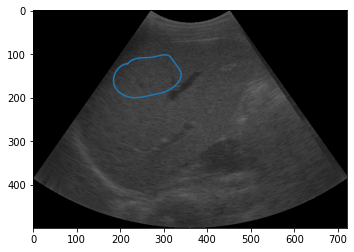

In [63]:
import matplotlib.pyplot as plt

plt.imshow(ultrasoundImage.scBmode)
plt.plot(scSplineX, scSplineY)

In [64]:
spectralData.drawCmaps()
spectralData.scanConvertCmaps()

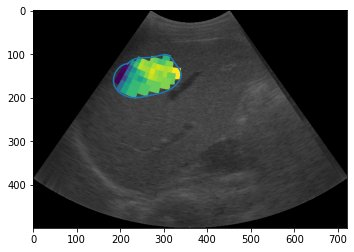

In [67]:
plt.imshow(spectralData.scMbfIm)
plt.plot(scSplineX, scSplineY)

In [68]:
import numpy as np
np.mean(spectralData.mbfArr), np.mean(spectralData.siArr), np.mean(spectralData.ssArr)

(22.727490424305888, 125.76141370069922, -2.2896116808381383e-05)